# Comparação entre Renda Fixa e Variável:
Neste notebook, pretendo simular como teria sido investir 100 reais por mês em uma aplicação CDB de liquidez diária rendendo 100% do CDI, simular como teria sido a evolução do recebimento de dividendos no mesmo período com compras mensais de algumas ações, considerar a inflação, e comparar os ganhos resultantes de cada estratégia.


Feito: 
- Comparação gráfica entre valores parados em conta-corrente e valores investidos em renda-fixa;
- Comparação gráfica não conclusiva entre as duas estratégias de investimento. 

A fazer: 
- Estabelecer as métricas que vão medir o dinheiro investido;
- Descontar a inflação;
- Considerar possíveis taxações;
- Comparar as estratégias.


In [1]:
        #--------------------------------# bibliotecas
        import requests                  #
        import numpy        as np        #
        import pandas        as pd       #
        import seaborn       as sns      #
        import yfinance       as yf      #
        import financefunction as ff     #
        import matplotlib.pyplot as plt  #
        #--------------------------------#

        #-------------------# prepara visualização:
        %matplotlib inline
        sns.set()           #
        #-------------------#

# Renda Fixa

Aqui, vamos simular como teria sido a evolução de um patrimônio construído pela estratégia de se investir 100 reais por mês em uma aplicação de renda fixa rendendo 100% CDI desde 01 de Janeiro de 2016 até o dia de hoje, e vamos comparar isto com como seria simplesmente guardar 100 reais por mês no mesmo período. Note que ainda não estamos considerando os efeitos da inflação e nem qualquer espécie de taxação.

Abaixo, temos uma função que consulta uma API do Banco Central e retorna dados solicitados (ver financefunction.py):

In [2]:
cdi  = ff.get_bc(12,  data_inicial='01/01/2016')  # Série temporal da taxa CDI (dia)
cdi.sample(3).sort_index() # os valores estão em %

,valor
data,
2019-12-30,0.017089
2021-09-17,0.019930
2021-09-28,0.023687


Abaixo, temos dois patrimonios iniciais de 100 reais acrescidos de mais 100 reais a cada mês. Um deles rendendo 100% de uma CDI de liquidez diária.

In [3]:
renda_fixa = 0    # esse patrimônio simulará um investimento em renda fixa
serie = [renda_fixa]

armazenado = 0   # esse patrimônio simulará depósitos simples
serie2 = [armazenado]
mes = 0

for dia in cdi.index[:-1]:
    if mes != dia.month:
        mes = dia.month
        renda_fixa  += 100
        armazenado += 100
    i = cdi.loc[dia][0]
    renda_fixa = renda_fixa*(1+i/100)
    serie.append(renda_fixa)
    serie2.append(armazenado)

serie = pd.Series(serie)
serie2 = pd.Series(serie2)
serie.index, serie2.index = cdi.index, cdi.index

## Gráfico 1:
Aqui plotamos um gráfico para comparar a diferença entre guardar dinheiro e investir em renda-fixa como feito acima. Vemos que a quantia investida parece crescer exponencialmente, o que é esperado em um regime de juros compostos. 

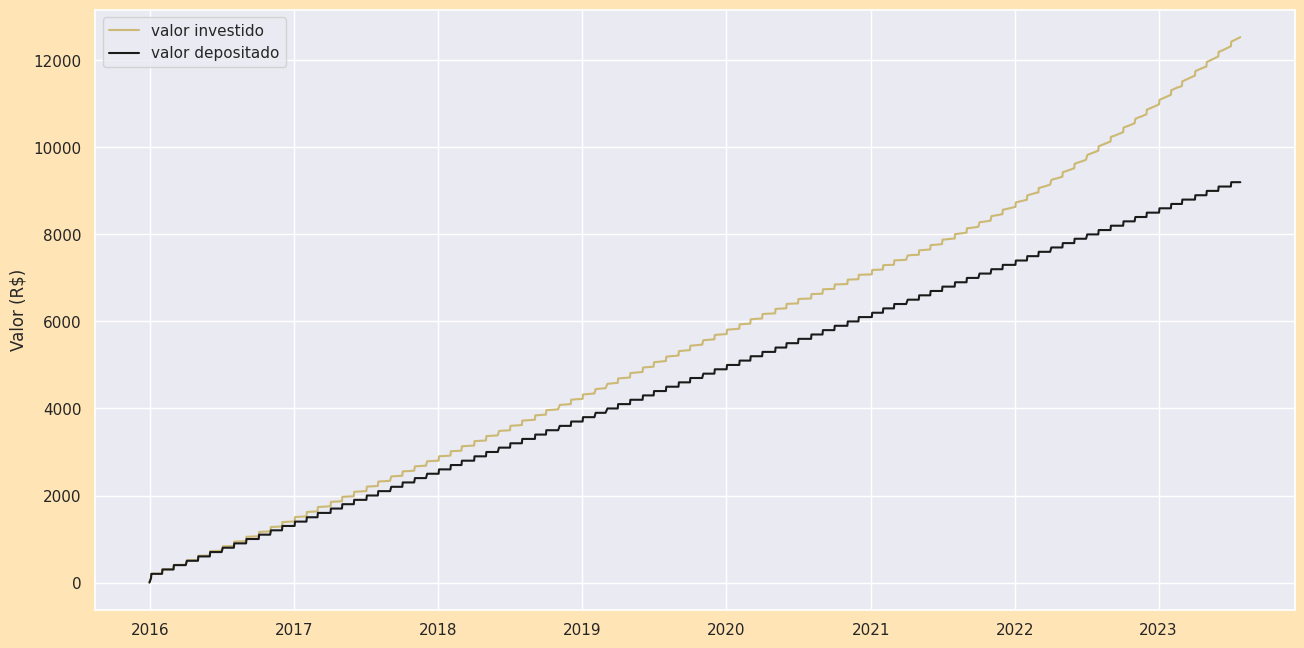

In [4]:
fig1 = plt.figure(figsize=(12,6), dpi=100, facecolor='moccasin')

axes1 = fig1.add_axes([0, 0, 1, 1])
axes1.plot(serie.index, serie, 'y', label='valor investido')
axes1.plot(serie2.index, serie2, 'k', label='valor depositado')
axes1.set_ylabel('Valor (R$)')
axes1.legend(loc=0)

## Gráfico 2:
Abaixo, temos o gráfico dos rendimentos acumulados ao longo do tempo. Isto é: no eixo das ordenadas, temos a diferença entre o total que foi investido até um determinado dia e o tanto de dinheiro que há na aplicação naquele mesmo dia.  

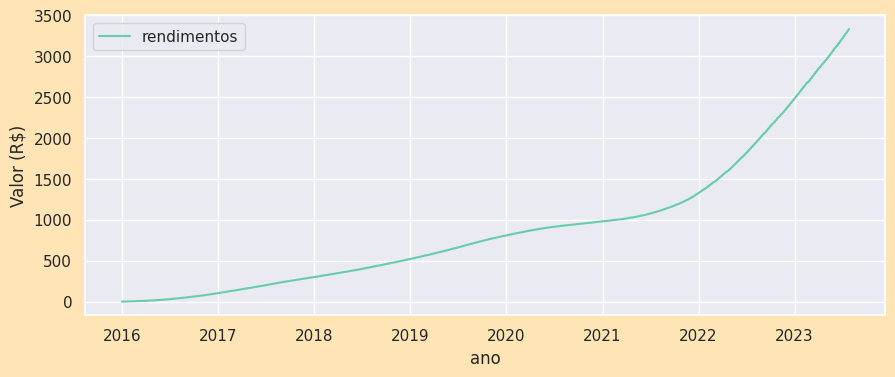

In [5]:
rendimentos = np.array(serie)-np.array(serie2)

fig1 = plt.figure(figsize=(8,3), dpi=100, facecolor='moccasin')

axes1 = fig1.add_axes([0, 0, 1, 1])
axes1.plot(cdi.index, rendimentos, color='mediumaquamarine', label='rendimentos')
axes1.set_ylabel('Valor (R$)')
axes1.set_xlabel('ano')
axes1.legend(loc=0)

# Renda Variável
Aqui, vamos simular como teria sido a evolução dos ganhos por dividendos de ações compradas mensalmente a partir de 01/01/2016. Na simulação, foram compradas ações todos os meses. No mínimo uma ação, ou quantas fossem possíveis comprar com 100 reais mais os dividendos já obtidos.   
## Gráfico 3:
Começamos importando os dados e também plotando o gráfico com os valores de fechamento da ação:

[*********************100%***********************]  1 of 1 completed


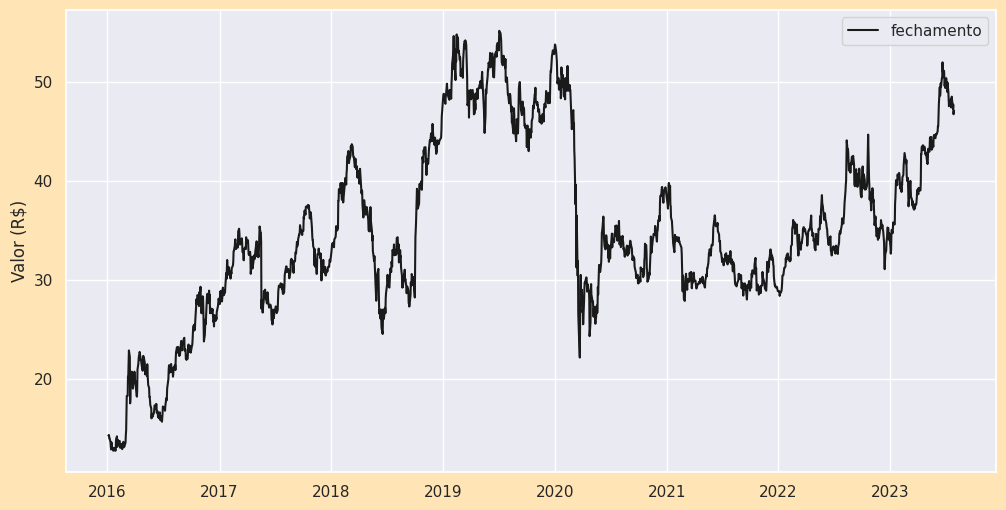

In [6]:
#---------------------------------------------------------------# 
t0 = pd.to_datetime('2016-01-01')                               #
t1 = pd.to_datetime('now')                                      #
papel = yf.download('BBAS3.SA', start=t0, end=t1, actions=True) # --> dataset
#---------------------------------------------------------------#

periodo = ('2016-01-01' <= papel.index) #---------> filtro

fig1 = plt.figure(figsize=(12,6), dpi=100, facecolor='moccasin')
plt.plot(papel[periodo]['Close'], 'k', label='fechamento')   
plt.ylabel('Valor (R$)')
plt.legend(loc=0)

Já aqui, rodamos a seguinte simulação: 
1. Todos os meses, compra-se pelo menos uma ação ou quantas ações forem possíveis com R$ 100,00 mais trocos e dividendos guardados. 
2. Guarda-se o troco, se houver. 
3. No dia em que se receber dividendos, junta-se os dividendos ao troco e, se for o suficiente para comprar ações, compra quantas forem possíveis e guarda-se o troco. 

Essa simulação, entretanto, sofre com o problema que é a dificuldade de garantir a veracidade e precisão dos dados puxados da plataforma yahoo finance pela biblioteca yfinance.

In [7]:
mes = 0
dividendos_em_conta = 0

dividendos = []
acoes = []
investido = []
acoes_do_mes = 0


for dia in papel.index:
    if dia.month != mes: # virada do mês
        mes = dia.month  
        acoes_do_mes = 1 # compra pelo menos uma ação,
        # ou o que der pra comprar com 100 reais + dinheiro obtido por dividendos:
        if papel.loc[dia]['Open'] < 100 + dividendos_em_conta: 
            acoes_do_mes = (100 + dividendos_em_conta)//papel.loc[dia]['Open'] 
        investido.append(acoes_do_mes*papel.loc[dia]['Open']) # registra quanto foi gasto em ações
        acoes.append(acoes_do_mes)
        dividendos_em_conta -= (acoes_do_mes*papel.loc[dia]['Open'] -100)
    else:
        acoes.append(0)
        investido.append(0)
    DY = 0
    if papel.loc[dia]['Dividends'] > 0.0:
        DY = papel.loc[dia]['Dividends']*(sum(acoes)-acoes_do_mes)
        dividendos_em_conta += DY
        if dividendos_em_conta >= papel.loc[dia]['Open']:
            dividendos_em_conta -= (dividendos_em_conta//papel.loc[dia]['Open'])*papel.loc[dia]['Open'] 
    dividendos.append(DY)
    
dividendos = pd.Series(dividendos)
acoes      = pd.Series(acoes)
investido  = pd.Series(investido)

dividendos.index = papel.index
acoes.index      = papel.index
investido.index  = papel.index

## Gráfico 4:
Plotamos lado a lado as seguintes curvas: 
- amarela: a mesma curva de rendimentos do Gráfico 3;
- preta: soma cumulativa de todos os dividendos que já foram recebidos

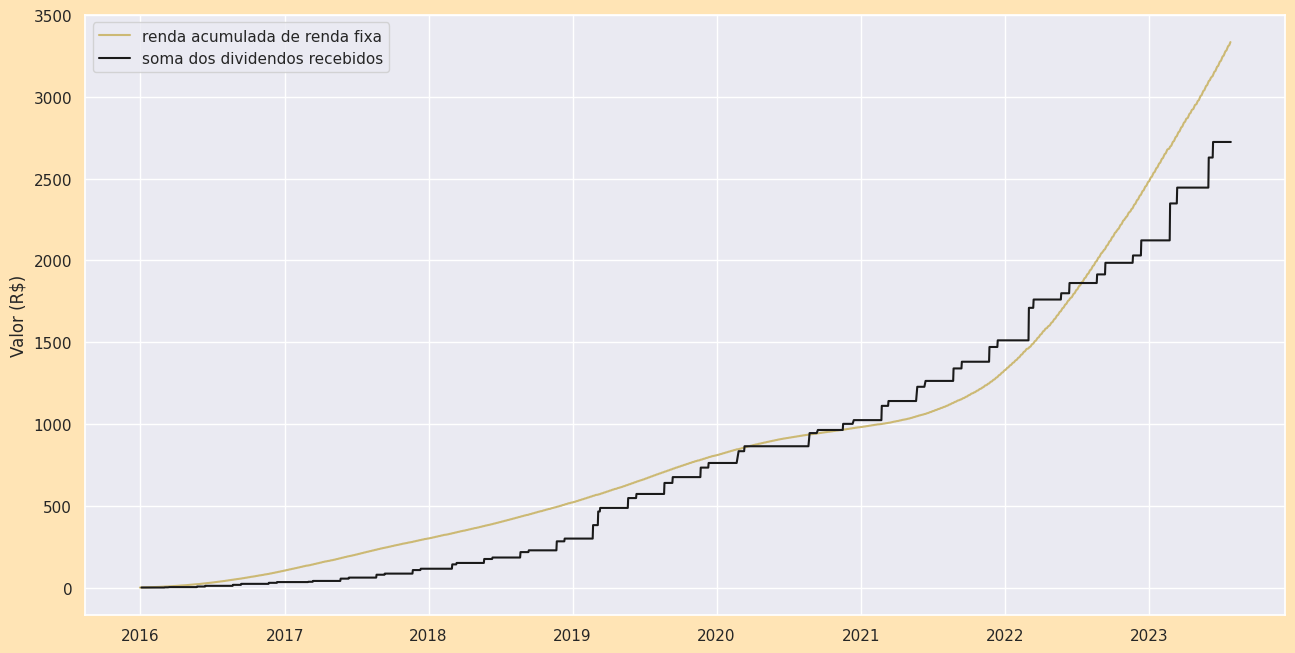

In [8]:
fig1 = plt.figure(figsize=(12,6), dpi=100, facecolor='moccasin')

axes1 = fig1.add_axes([0, 0, 1, 1])
axes1.plot(cdi.index, rendimentos, 'y', label='renda acumulada de renda fixa')
axes1.plot(dividendos.index, dividendos.cumsum(), 'k', label='soma dos dividendos recebidos')
axes1.set_ylabel('Valor (R$)')
axes1.legend(loc=0)

Esse gráfico não é conclusivo. Há dificuldades em se comparar os ganhos por dividendos e os ganhos por renda fixa. As métricas para comparação ainda não foram estabelecidas. Provavelmente já há uma ou várias métricas formas conhecidas de se comparar. Vou pesquisar o tema assim que cansar de tentar descobrir uma boa forma de comparar as duas estratégias. 